In [110]:
import numpy as np
import matplotlib.pyplot as plt
import random
import functools
import pandas as pd
import umap.umap_ as umap
import seaborn as sns
from numpy.random import default_rng
from numpy import negative
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy

random.seed(a=12)

# Part 1

In this first part, we investigate the data of hand-written digits, and use two algorithms to classify the images: naive methods, and a KNN classifier.

In [108]:
# read in the data
trainin = pd.read_csv('data/train_in.csv', delimiter = ',', header=None)
trainout = pd.read_csv('data/train_out.csv', delimiter = ',', header=None)
testin = pd.read_csv('data/test_in.csv', delimiter = ',', header=None)
testout = pd.read_csv('data/test_out.csv', delimiter = ',', header=None)

In [2]:
# add label data to trainin
trainin['Label'] = trainout
average = trainin.groupby(['Label']).mean()

train = trainin.iloc[:, :-1]

Firstly, we take the average vector of each digit, and calculate the differences between these vectors.

In [3]:
def group_and_calc_dist(data, labels, no1, no2):
    """
    Takes data (train or test in) and labels (train or test out) in a dataframe 
    and two numbers. Calculates the distance between the centers of those two numbers.
    """
    data['Label'] = labels
    average = data.groupby(['Label']).mean()
    dist = np.linalg.norm(average.iloc[[no1]].to_numpy() - average.iloc[[no2]].to_numpy())
    
    return dist

# print distances between centres of digits
plotlist = []
for a in range(0, 10):
    subplotls = []
    for b in range(0, 10):
        subplotls.append(group_and_calc_dist(trainin, trainout, a, b))
        print('Number one: ', a, ' Number two: ', b, ' Distance: ', group_and_calc_dist(trainin, trainout, a, b))
    plotlist.append(subplotls)
       

Number one:  0  Number two:  0  Distance:  0.0
Number one:  0  Number two:  1  Distance:  14.44960796590658
Number one:  0  Number two:  2  Distance:  9.334555870229643
Number one:  0  Number two:  3  Distance:  9.143733671882783
Number one:  0  Number two:  4  Distance:  10.769844437633486
Number one:  0  Number two:  5  Distance:  7.519296259597183
Number one:  0  Number two:  6  Distance:  8.154443125778972
Number one:  0  Number two:  7  Distance:  11.864555054634078
Number one:  0  Number two:  8  Distance:  9.907901737320392
Number one:  0  Number two:  9  Distance:  11.488874937417041
Number one:  1  Number two:  0  Distance:  14.44960796590658
Number one:  1  Number two:  1  Distance:  0.0
Number one:  1  Number two:  2  Distance:  10.125322577096668
Number one:  1  Number two:  3  Distance:  11.733232901831071
Number one:  1  Number two:  4  Distance:  10.173786431281787
Number one:  1  Number two:  5  Distance:  11.118800407467436
Number one:  1  Number two:  6  Distance:  10

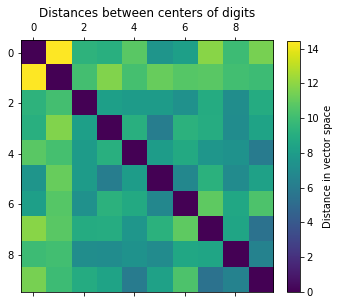

In [4]:
plt.figure(figsize=(5, 8))
plt.matshow(plotlist, fignum = 1)
plt.title("Distances between centers of digits")
plt.colorbar(fraction = .045, label = 'Distance in vector space')
plt.show()

Now, we use three different dimension reduction methods to visualize the data.

In [5]:
# define and perform dimension reduction
pca = PCA(n_components = 2)
youmap = umap.UMAP()
tsne = TSNE()

tsnereduc = tsne.fit_transform(trainin)
umapreduc = youmap.fit_transform(trainin)
pcareduc = pca.fit_transform(trainin)

Text(0.5, 1.0, 'TSNE Dimension Reduction')

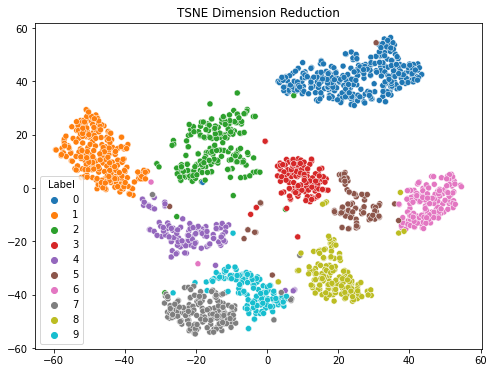

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsnereduc[:, 0], y = tsnereduc[:, 1], hue = trainin["Label"], legend = 'full', palette = sns.color_palette("tab10"))
plt.title('TSNE Dimension Reduction')

Text(0.5, 1.0, 'Umap Dimension Reduction')

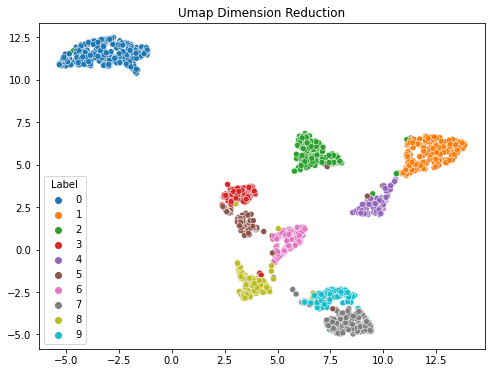

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapreduc[:, 0], y = umapreduc[:, 1], hue = trainin["Label"], legend = 'full', palette = sns.color_palette("tab10"))
plt.title("Umap Dimension Reduction")

Text(0.5, 1.0, 'PCA Dimension Reduction')

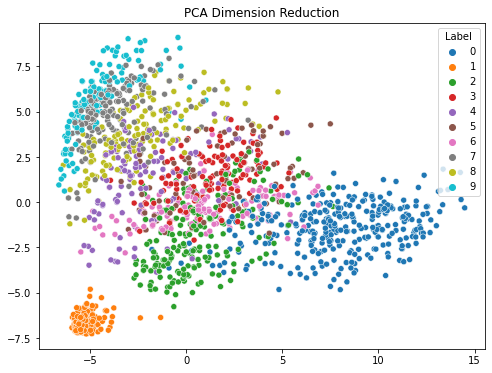

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcareduc[:, 0], y = pcareduc[:, 1], hue = trainin["Label"], legend = 'full', palette = sns.color_palette("tab10"))
plt.title('PCA Dimension Reduction')

Using the average vectors per digit, we classify the data and check the performance of this naive method.

In [89]:
predstest = []
predstrain = []

for index, measure in train.iterrows():
    disttrain = 1000
    notrain = 1000
    for index2, mean in average.iterrows():
        currentdisttr = np.linalg.norm(mean.to_numpy() - measure.to_numpy())
        if currentdisttr < disttrain:
            disttrain = currentdisttr
            notrain = index2
    predstrain.append(notrain)
    
for index, measure in testin.iterrows():
    disttest = 1000
    notest = 1000
    for index2, mean in average.iterrows():
        currentdistte = np.linalg.norm(mean.to_numpy() - measure.to_numpy())
        if currentdistte < disttest:
            disttest = currentdistte
            notest = index2
    predstest.append(notest)
    
traincorrect = 0
testcorrect = 0
traintotal = 0
testtotal = 0
i = 0
j = 0

for pred in predstrain:
    if trainout[0][i] == pred:
        traincorrect += 1
    traintotal += 1
    i += 1
    
for pred in predstest:
    if testout[0][j] == pred:
        testcorrect += 1
    testtotal += 1
    j += 1
    
print("Train percentage correct: ", traincorrect/traintotal*100)
print("Test percentage correct: ", testcorrect/testtotal*100)

Train percentage correct:  86.35032220269478
Test percentage correct:  80.4


We do the same with a KNN classifier, to be able to compare the results.

In [105]:
knn = KNeighborsClassifier()
knn.fit(trainin.iloc[:, :-1], trainout[0])
predictions = knn.predict(testin)

knncorrect = 0
knntotal = 0
k = 0
for pred in predictions:
    if testout[0][k] == pred:
        knncorrect += 1
    knntotal += 1
    k += 1
print("KNN percentage correct: ", knncorrect/knntotal*100)

KNN percentage correct:  90.8


Lastly, we plot the confusion matrices of both methods.

In [110]:
lbls = [0,1,2,3,4,5,6,7,8,9]
naivematrix = confusion_matrix(predstest, testout[0])
knnmatrix = confusion_matrix(predictions, testout[0])

matrix1 = ConfusionMatrixDisplay(confusion_matrix = naivematrix, display_labels = lbls)
matrix2 = ConfusionMatrixDisplay(confusion_matrix = knnmatrix, display_labels = lbls)

Text(0.5, 1.0, 'Naive Confusion Matrix')

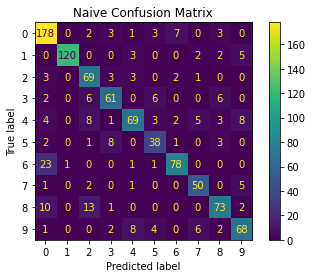

In [117]:
matrix1.plot()
plt.title("Naive Confusion Matrix")

Text(0.5, 1.0, 'KNN Confusion Matrix')

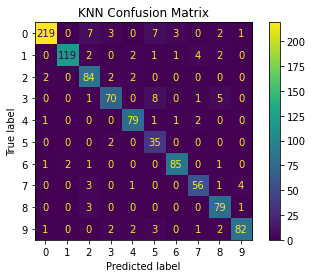

In [116]:
matrix2.plot()
plt.title("KNN Confusion Matrix")

# Part 2

In this next part, we implement a multiclass single layer perceptron to classify the same data as in part 1.

In [36]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

train_in = pd.read_csv('train_in.csv', header=None)
train_out = pd.read_csv('train_out.csv', header=None)
test_in = pd.read_csv('test_in.csv', header=None)
test_out = pd.read_csv('test_out.csv', header=None)

In [19]:
# insert a column of one in the train set for the bias
train_in.insert(0, 'w0', 1)
test_in.insert(0, 'w0', 1)

# generate Weights randomly
rng = default_rng(seed=42) # ?-> do i have to change the seed different and calculate the mean
vals = rng.standard_normal(size=(257, 10)) # standard Gaussian
W = preprocessing.MaxAbsScaler().fit_transform(vals) # uniform (on [-1, 1])

delta_w = np.full((257, 10), 0.00)

# encode the desired label to binary colomns
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
trainout = pd.DataFrame(encoder.fit_transform(train_out).toarray())
testout = pd.DataFrame(encoder.fit_transform(test_out).toarray())

In [34]:
# train the network on train set
mse = 100
while mse > 0.01:
    prediction = []
    for index, x in train_in.iterrows():
        pre = np.full((1, 9), 0.00)
        net = np.dot(x, W)           # linear regression
        out = 1 / (1 + np.exp(-net)) # logistic regression
        digit = np.argmax(out)
        output = np.insert(pre, digit, 1)
        prediction.append(output)
        # generate the delta w using neuron learning rule
        for i in range(trainout.shape[1]): 
            w_tran = 0.1 * x * (trainout.iloc[index].iloc[i] - out[i]) * out[i] * (1 - out[i])
            w_tran = w_tran.values
            w_tran = w_tran.reshape(1,-1).T
            delta_w[:, i] = w_tran[:, 0]
        W += delta_w
    mse = mean_squared_error(trainout.values, prediction)

In [35]:
# calculate the accuracy
traincorrect = 0
for i, x in train_in.iterrows():
    pre = np.full((1, 9), 0.00)
    phi = 1 / (1 + np.exp(-np.dot(x, W)))
    output = np.insert(pre, np.argmax(phi), 1)
    if np.array_equiv(trainout.values[i], output):
        traincorrect += 1
correctr_train = traincorrect / len(train_in) * 100

testcorrect = 0
for j, x in test_in.iterrows():
    pre = np.full((1, 9), 0.00)
    phi = 1 / (1 + np.exp(-np.dot(x, W)))
    output = np.insert(pre, np.argmax(phi), 1)
    if np.array_equiv(testout.values[j], output):
        testcorrect += 1
correctr_test = testcorrect / len(test_in) * 100

print('Train percentage correct: %f' % correctr_train)
print('Test percentage correct: %f' % correctr_test)

Train percentage correct: 97.656708
Test percentage correct: 87.800000


# Part 3

In this last part, we implement an XOR network from scratch, and experiment with the parameters of the model to see what effects this has on the model's performance. We first define different node types for nodes with specific activation functions. Then, we define the neural network. Lastly, we perform the experiments and plot the necessary graphs. 

### Sigmoid Implementation
Activation Function: $$\frac{1}{1 + e^{-x}}$$

In [2]:
class Node:
    def __init__(self, id, type, parents, weights, neuralNetwork):
        self.id = id
        self.type = type
        self.parents = parents
        self.weights = weights
        self.inputs = {}
        self.output = 0
        self.children = []
        self.neuralNetwork = neuralNetwork
        # print(f"{self.type} node {self.id} created with weights {self.weights}.")
    def setValue(self, setterID, value):
        self.inputs[setterID] = value
        if len(self.inputs) == len(self.weights):
            self.ActivationFunction()

    def AddChildren(self, children):
        self.children = children
        # for child in children:
            # print(f"{child.id} added as child of {self.id}.")
        if self.type == "Hidden" or self.type == "Input":
            if len(children) == 0:
                raise f"{self.type} node added 0 children."

    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        phi = 0
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i
            phi += 1
            phi *= -1                                                                        # fixed bias 1
            localResult = 1 / (1 + (np.e ** (phi)))
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= (self.result * (1 - self.result))
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta 
        elif (self.type == "Output"):
            delta = self.result * (1 - self.result) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

    
    def getChildrenWeights(self):
        weight = {}
        if len(self.children) != 0:
            for child in self.children:
                weight[child.id] = child.weights[self.id]
        return weight

### ReLu Implementation
Activation function: $$max(0,x)$$


In [3]:
class ReLUNode(Node):
    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        phi = 0
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i
            phi += 1                                                                        # fixed bias 1
            localResult = max(0, phi)
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= max(0, delta + 1)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta 
        elif (self.type == "Output"):
            phi = 0
            for key in self.weights.keys():
                phi += self.weights[key] * self.inputs[key]
            delta = max(0, phi + 1) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

### Tanh Implementation
Activation Function:
$$\tanh (x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [4]:
class TanhNode(Node):
    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            phi = 1                                                                        # fixed bias 1
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i + 1
            localResult = np.tanh(phi)
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= (1 - (self.output ** 2))
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta
        elif (self.type == "Output"):
            delta = (1 - self.output ** 2) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

### Defining the neural network

In [5]:
def NodePicker(type):
    if type == "Sigmoid":
        return Node
    elif type == "ReLU":
        return ReLUNode
    elif type == "Tanh":
        return TanhNode
    else:
        raise "type unknown, valid options \"Sigmoid\", \"Tanh\" and \"ReLU\""

In [105]:
class NeuralNetwork:
    def __init__(self, inputCount, hiddenlayerWidth, hiddenLayerDepth, outputCount, activationFunction):
        if type(hiddenLayerDepth) != int or type(hiddenlayerWidth) != int or type(outputCount) != int or type(inputCount) != int:
            raise "All inputs are supposed to be integer."
        self.id = "neuralNetwork"
        self.output = 0
        currentLayer = []
        parentLayer = []
        layerCounter = 0
        for nodeNumber in range(1, inputCount + 1):
            currentLayer.append(NodePicker(activationFunction)(id=f"({layerCounter},{nodeNumber})", type="Input", parents=[self], weights={self.id: 1}, neuralNetwork=self))
        self.networkHead = currentLayer
        for hiddenLayerNumber in range(1, hiddenLayerDepth + 1):
            parentLayer = currentLayer
            currentLayer = []
            for nodeNumber in range(1, hiddenlayerWidth + 1):
                weights = {}
                for parent in parentLayer:
                    weights[parent.id] = random.random()
                node = NodePicker(activationFunction)(id=f"({hiddenLayerNumber}, {nodeNumber})", type="Hidden", parents=parentLayer, weights=weights, neuralNetwork=self)
                currentLayer.append(node)
            for parent in parentLayer:
                parent.AddChildren(currentLayer)
        parentLayer = currentLayer
        currentLayer = []
        layerCounter += (hiddenLayerDepth + 1)
        for outputCount in range(1, outputCount + 1):
            weights = {}
            for parent in parentLayer:
                weights[parent.id] = random.random()
            node = NodePicker(activationFunction)(id=f"({layerCounter}, {outputCount})", type="Output", parents=parentLayer, neuralNetwork=self, weights=weights)
            currentLayer.append(node)
        for parent in parentLayer:
            parent.AddChildren(children=currentLayer)
        self.outputLayer = currentLayer
        
    def LazyWeightUpdater(self, iterations, inputs, outputs, stepSize):
        workingWeights = {}
        bestWeights = {}       # {toNode : {fromNode : Value}}
        nodeMap = {}
        currentLayer = self.networkHead[0].children
        errorProgression = []
        while len(currentLayer) != 0:
            for node in currentLayer:
                nodeMap[node.id] = node
                workingWeights[node.id] = node.weights
            currentLayer = currentLayer[0].children
        bestWeights = workingWeights
        leastError = np.average(self.GetError(inputs, outputs))
        self.FlushNeuralNetwork()
        for iteration in range(iterations):
            for key1 in workingWeights:
                for key2 in workingWeights[key1]:
                    workingWeights[key1][key2] += (stepSize * random.random() - stepSize/2)
                    nodeMap[key1].weights[key2] = workingWeights[key1][key2]
                    currentError = np.average(self.GetError(inputs, outputs))
                    self.FlushNeuralNetwork()
                    if currentError < leastError:
                        leastError = currentError
                        bestWeights = workingWeights
                    errorProgression.append(leastError)
        print(f"Best weights = {bestWeights}, with accuracy {(1 - leastError) * 100}%")
        return errorProgression
    
    def GetError(self, inputs, outputs):
        if len(inputs) != len(outputs):
            raise f"Input output count mismatch. Input: {len(inputs)} Output: {len(outputs)}."
        nnOutput = []
        error = []
        for input in inputs:
            self.networkHead[0].setValue(setterID = self.id, value = input[0])
            self.networkHead[1].setValue(setterID = self.id, value = input[1])
            nnOutput.append(self.output)
        for i in range(0, len(outputs)):
            error.append((nnOutput[i] - outputs[i]) * (nnOutput[i] - outputs[i]))
        return error

    def BackTrack(self, learningRate, desiredOutput):
        if len(self.outputLayer) == 0:
            raise "No output layer to backtrack from."
        currentLayer = self.outputLayer
        previousDelta = {}
        deltaLayer = {}
        while type(currentLayer[0]) != type(self):
            for node in currentLayer:
                delta = node.UpdateWeights(previousDelta=previousDelta, eta = learningRate, desiredOutput = desiredOutput)
                deltaLayer[node.id] = delta
            previousDelta = deepcopy(deltaLayer)
            deltaLayer.clear()
            currentLayer = currentLayer[0].parents

    def FlushNeuralNetwork(self):
        currentLayer = self.networkHead
        while len(currentLayer) != 0:
            for node in currentLayer:
                node.inputs.clear()
            currentLayer = currentLayer[0].children

    def Train(self, epoches, inputs, outputs, learningRate):
        errors = []
        nnOutputs = []
        for i in range(1, epoches + 1):
            temporaryErrors = 0
            for j in range(len(inputs)):
                self.networkHead[0].setValue(setterID=self.id, value=inputs[j][0])
                self.networkHead[1].setValue(setterID=self.id, value=inputs[j][1])
                temporaryErrors += ((self.output - outputs[j]) * (self.output - outputs[j]))
                # print(f"Desired input and output: {input[j][0], input[j][1]}, {output[j]}")
                self.BackTrack(learningRate=learningRate, desiredOutput=outputs[j])
                nnOutputs.append(self.output)
                self.FlushNeuralNetwork()
            temporaryErrors /= len(outputs)
            errors.append(temporaryErrors) 
        return errors, nnOutputs

### Defining a function to retrieve the error and plot the results

In [98]:
def plotGraphs(lr, iterations, nodeType, graphs):
    nn = NeuralNetwork(inputCount=2, hiddenlayerWidth=2, hiddenLayerDepth=1, outputCount=1, activationFunction=nodeType)
    nn.outputLayer[0].weights
    nn.FlushNeuralNetwork()
    errors, nnOutputs = nn.Train(epoches=iterations, inputs=input, outputs=output, learningRate=lr)
    outputDict = {}
    for index in range(len(nnOutputs)):
            if outputDict.keys().__contains__(str(input[index % 4])):
                outputDict[str(input[index % 4])].append(nnOutputs[index])
            else:
                outputDict[str(input[index % 4])] = [nnOutputs[index]]
    if graphs:
        for key in outputDict.keys():
            plt.plot(range(1, len(outputDict[key]) + 1), outputDict[key], label=key)
        plt.ylabel('Output value')
        plt.xlabel('Epoch')
        plt.legend()
        plt.title(f"Output values of network for multiple iterations, learning rate:{lr}, iterations:{iterations} ({nodeType})")
        plt.show()
        plt.plot(range(1, len(errors) +1), errors)
        plt.ylabel('Error')
        plt.xlabel('Epoch')
        plt.title(f"Error of network for multiple iterations, learning rate: {lr}, iterations, {iterations}")
        plt.show()
    errors = np.array(errors)
    finalError = nn.GetError(inputs=input, outputs=output)
    fel = len(finalError)
    finalError = functools.reduce(lambda a, b: a + b, finalError)
    return finalError/fel

### Running experiments

With the neural network defined, we move on to defining and running the experiments.

In [86]:
# define different types of inputs to experiment with
noisyInput = [[0.1, 0.1], [0.1, 1], [1, 0.1], [1, 1]]
standardInput = [[0, 0], [0, 1], [1, 0], [1, 1]]
negativeInput = [[0, 0], [0, 1], [1, 0], [1, -1]]

normalOutput = [0, 1, 1, 0]
negativeOutput = [0, -1, -1, 0]

output = normalOutput

# define lists of parameters to test
learningRate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
iterations = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [125]:
dfsig = pd.DataFrame(columns=learningRate)
dftanh = pd.DataFrame(columns=learningRate)
dfrelu = pd.DataFrame(columns=learningRate)

In [126]:
input = standardInput
output = normalOutput

# run models with different activation functions and parameters on normal data
for lr in learningRate:
    columnsig = []
    columnrelu = []
    columntanh = []
    
    for iteration in iterations:
        
        errorsig = plotGraphs(lr=lr, iterations=iteration, nodeType="Sigmoid", graphs=False)
        errorrelu = plotGraphs(lr=lr, iterations=iteration, nodeType="ReLU", graphs=False)
        errortanh = plotGraphs(lr=lr, iterations=iteration, nodeType="Tanh", graphs=False)
        
        columnsig.append(errorsig)
        columnrelu.append(errorrelu)
        columntanh.append(errortanh)
        
    dfsig[lr] = columnsig
    dfrelu[lr] = columnrelu
    dftanh[lr] = columntanh
    
dfsig.index = iterations
dfrelu.index = iterations
dftanh.index = iterations

Below, we print the errors of each model for the different activation functions.

In [127]:
dfsig

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,0.254036,0.251966,0.249930,0.250212,0.250446,0.246624,0.250461,0.249741,0.251067,0.244069
256,0.251441,0.249767,0.251258,0.249206,0.249762,0.245209,0.249909,0.247701,0.239231,0.222869
512,0.250770,0.251020,0.248425,0.240528,0.236164,0.234909,0.233320,0.207705,0.196482,0.199785
1024,0.249501,0.238488,0.224502,0.215982,0.208486,0.196071,0.172620,0.196984,0.192488,0.166782
2048,0.249649,0.216030,0.199259,0.192627,0.190499,0.168131,0.189340,0.189072,0.189237,0.188855
4096,0.214563,0.192174,0.190565,0.186798,0.183202,0.188383,0.160142,0.188279,0.188258,0.160950
8192,0.192795,0.162350,0.188323,0.188063,0.157205,0.181448,0.187950,0.187936,0.181077,0.188069
16384,0.189139,0.188050,0.181514,0.187744,0.159930,0.187742,0.187748,0.187802,0.187875,0.180700


In [118]:
dfrelu

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,0.303010,0.500084,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
256,0.306874,0.255079,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
512,0.500023,0.250014,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1024,0.250020,0.250006,0.500001,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2048,0.250008,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4096,0.250001,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
8192,0.250000,0.500000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
16384,0.250000,0.250000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [119]:
dftanh

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,0.252120,0.270051,0.273935,0.280424,0.291169,0.304413,0.314812,0.316487,0.307038,0.289854
256,0.259469,0.270874,0.274053,0.280426,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854
512,0.267038,0.271201,0.274053,0.280424,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854
1024,0.266817,0.271136,0.274053,0.280424,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854
2048,0.269972,0.271136,0.274053,0.280424,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854
4096,0.270095,0.271136,0.274053,0.280424,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854
8192,0.270095,0.271136,0.274053,0.280424,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854
16384,0.270095,0.271136,0.274053,0.280424,0.291169,0.304413,0.314815,0.316487,0.307038,0.289854


Given these errors, we now plot the graphs of the neural nets with the smallest errors.

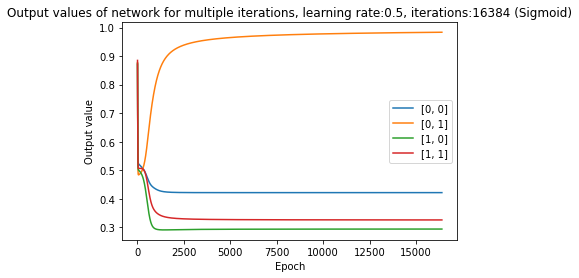

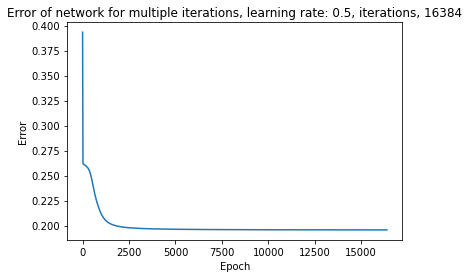

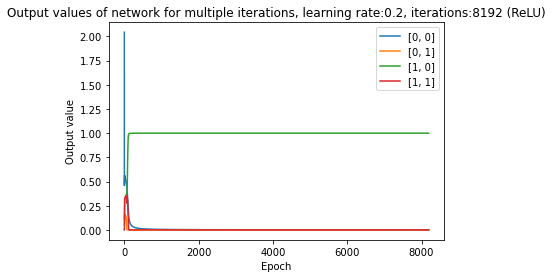

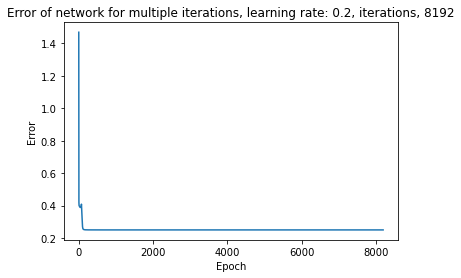

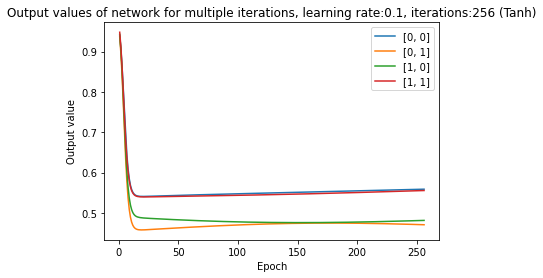

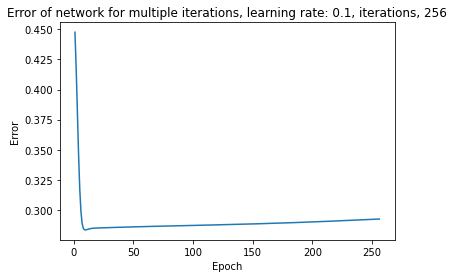

0.2593386022394653

In [100]:
input = standardInput
plotGraphs(lr=0.5, iterations=16384, nodeType="Sigmoid", graphs=True)
plotGraphs(lr=0.2, iterations=8192, nodeType="ReLU", graphs=True)
plotGraphs(lr=0.1, iterations=256, nodeType="Tanh", graphs=True)

Now, we will do the same, but using the noisy input. This input may improve the performance of the model.

In [92]:
dfsignoisy = pd.DataFrame(columns=learningRate)
dftanhnoisy = pd.DataFrame(columns=learningRate)
dfrelunoisy = pd.DataFrame(columns=learningRate)

In [93]:
input = noisyInput
output = normalOutput

# run models with different activation functions and parameters on noisy data
for lr in learningRate:
    columnsignoisy = []
    columnrelunoisy = []
    columntanhnoisy = []
    
    for iteration in iterations:
        
        errorsig = plotGraphs(lr=lr, iterations=iteration, nodeType="Sigmoid", graphs=False)
        errorrelu = plotGraphs(lr=lr, iterations=iteration, nodeType="ReLU", graphs=False)
        errortanh = plotGraphs(lr=lr, iterations=iteration, nodeType="Tanh", graphs=False)
        
        columnsignoisy.append(errorsig)
        columnrelunoisy.append(errorrelu)
        columntanhnoisy.append(errortanh)
        
    dfsignoisy[lr] = columnsignoisy
    dfrelunoisy[lr] = columnrelunoisy
    dftanhnoisy[lr] = columntanhnoisy
    
dfsignoisy.index = iterations
dfrelunoisy.index = iterations
dftanhnoisy.index = iterations

In [94]:
dfsignoisy

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,0.251823,0.252447,0.251254,0.251033,0.250513,0.249130,0.250763,0.247014,0.249324,0.251119
256,0.252568,0.250783,0.250471,0.249930,0.248832,0.250542,0.248583,0.231104,0.250451,0.214722
512,0.251136,0.249878,0.250039,0.246097,0.230632,0.239274,0.216639,0.195016,0.204801,0.246545
1024,0.248840,0.248868,0.229159,0.233054,0.189778,0.167007,0.213521,0.183447,0.129330,0.148427
2048,0.246134,0.227703,0.216983,0.148008,0.120109,0.165317,0.131017,0.050551,0.054965,0.043643
4096,0.215577,0.141446,0.120510,0.047056,0.058878,0.022958,0.017553,0.020427,0.013971,0.011101
8192,0.185439,0.087434,0.029619,0.020640,0.174328,0.007882,0.005448,0.004584,0.171049,0.018597
16384,0.072142,0.175725,0.007710,0.004514,0.003095,0.002541,0.002009,0.001712,0.001434,0.001243


In [95]:
dfrelunoisy

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,0.263800,0.2511,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
256,0.258146,0.5000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
512,0.250640,0.5000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1024,0.250190,0.5000,0.500001,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2048,0.250015,0.5000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4096,0.250001,0.5000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
8192,0.250000,0.5000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5
16384,0.250000,0.5000,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [96]:
dftanhnoisy

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,0.257548,0.258328,0.254223,0.255366,0.265702,0.279064,0.292618,0.300278,0.293043,0.263422
256,0.257464,0.254850,0.269543,0.256426,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422
512,0.255573,0.249037,0.251499,0.256565,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422
1024,0.249435,0.248910,0.251932,0.256566,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422
2048,0.247523,0.250041,0.251932,0.256566,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422
4096,0.248776,0.250341,0.251932,0.256566,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422
8192,0.248943,0.250333,0.251932,0.256566,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422
16384,0.248943,0.250333,0.251932,0.256566,0.265802,0.279064,0.292618,0.300278,0.293043,0.263422


Just like previously, we will create a graph of the best performing networks with the noisy data.

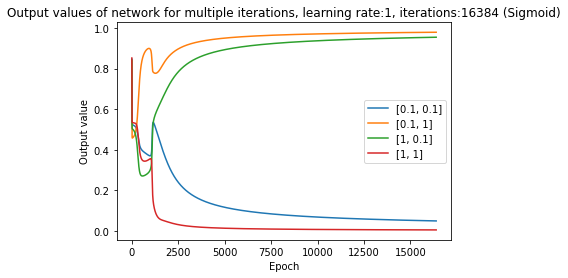

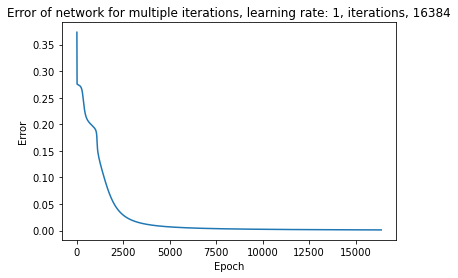

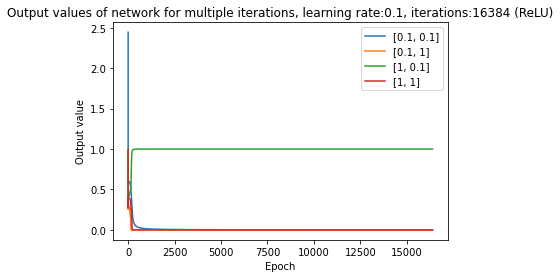

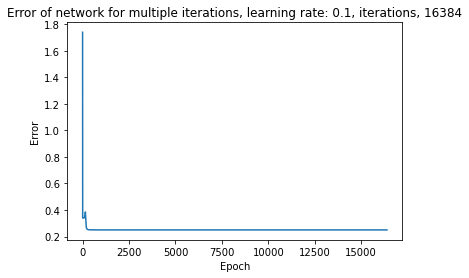

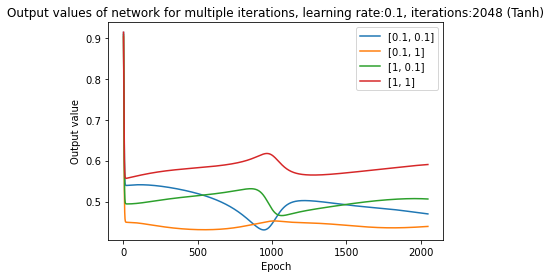

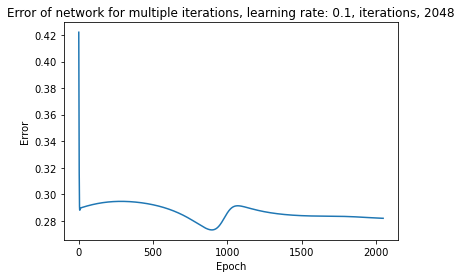

0.24757238298321307

In [101]:
input = noisyInput
plotGraphs(lr=1, iterations=16384, nodeType="Sigmoid", graphs=True)
plotGraphs(lr=0.1, iterations=16384, nodeType="ReLU", graphs=True)
plotGraphs(lr=0.1, iterations=2048, nodeType="Tanh", graphs=True)

From these results, we can see that the sigmoid model converges. To try and get the tanh network to do the same, we add noise in the data by changing part of the input to -1 in stead of 1.

In [102]:
input = negativeInput
dftanhneg = pd.DataFrame(columns=learningRate)

# run tanh model on negative input
for lr in learningRate:
    columntanhneg = []
    for iteration in iterations:
        errortanhneg = plotGraphs(lr=lr, iterations=iteration, nodeType="Tanh", graphs=False)
        columntanhneg.append(errortanhneg)
    dftanhneg[lr] = columntanhneg
dftanhneg.index = iterations

dftanhneg

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
128,1.933355e-03,2.836887e-05,1.246751e-05,7.144486e-07,2.597548e-03,0.202816,0.203239,0.200135,0.016082,0.192708
256,3.138435e-05,2.629850e-06,7.751075e-07,4.320604e-07,2.401225e-03,0.005959,0.015375,0.200135,0.195143,0.192707
512,2.444501e-06,5.917316e-07,2.486443e-07,1.293082e-07,2.006068e-01,0.202814,0.203237,0.200135,0.021746,0.192707
1024,5.784007e-07,8.374790e-06,3.859770e-04,3.893669e-08,1.795342e-08,0.006290,0.203237,0.200135,0.024499,0.194639
2048,1.148399e-07,3.289347e-08,1.616375e-03,1.071713e-08,4.092044e-03,0.017300,0.010377,0.200135,0.195143,0.192707
4096,2.802969e-08,3.028805e-08,1.244980e-08,1.437452e-04,1.132768e-03,0.007899,0.023567,0.200135,0.017563,0.023262
8192,6.835783e-09,1.862188e-09,6.594797e-05,8.754219e-05,3.204255e-03,0.007899,0.010832,0.033922,0.022937,0.648534
16384,2.209793e-09,1.737185e-03,3.363531e-05,6.647111e-05,7.517298e-03,0.203046,0.010320,0.015796,0.425563,0.194639


From this table, we can see that now the tanh model also converges. The best version is plotted below. The graph shows that the tanh function keeps fluctuating rapidly, and doesn't stabilize as much as the sigmoid model.

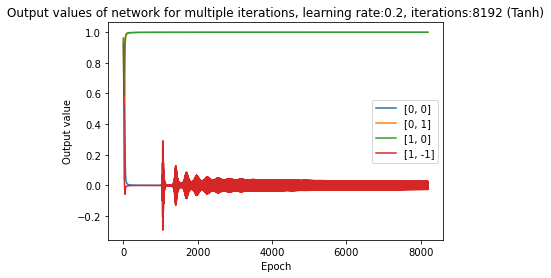

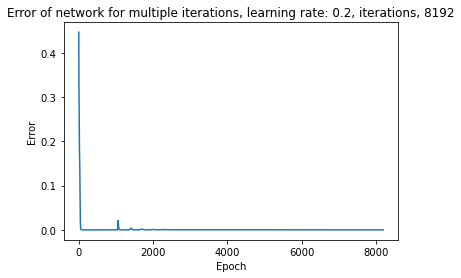

0.00017720708872694628

In [103]:
input = negativeInput
plotGraphs(lr=0.2, iterations=8192, nodeType="Tanh", graphs=True)

Lastly, we implemented the 'lazy method' as mentioned in the assignment. Each epoch, we generate random weights, and let the model run until convergence. The results, together with the combination of best weights, can be seen below. In the plot, each epoch shows the lowest error found up until that point.

Best weights = {'(1, 1)': {'(0,1)': -47.89841256386335, '(0,2)': 39.202902472820796}, '(1, 2)': {'(0,1)': 31.581131425669966, '(0,2)': 25.428362945254282}, '(2, 1)': {'(1, 1)': 53.258223117547914, '(1, 2)': -7.592674527761465}}, with accuracy 84.279633627824%


Text(0.5, 1.0, "Lowest error up until each given each epoch using 'lazy method' (sigmoid)")

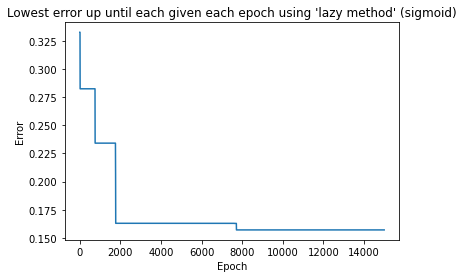

In [113]:
nn = NeuralNetwork(2, 2, 1, 1, "Sigmoid")
errors = nn.LazyWeightUpdater(2500, noisyInput, normalOutput, 5)
errors
plt.plot(range(1, len(errors)+1), errors)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Lowest error up until each given each epoch using 'lazy method' (sigmoid)")